In [99]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
import numpy as np

In [100]:

def detect_outliers_iqr(data):
    # Compute the first and third quartiles
    Q1, Q3 = np.percentile(data, [25, 75])
    IQR = Q3 - Q1
    
    # Define lower and upper bounds
    lower_bound = Q1 - 2 * IQR
    upper_bound = Q3 + 2 * IQR
    
    # Identify outliers
    outliers = (data < lower_bound) | (data > upper_bound)
    return outliers, lower_bound, upper_bound


def plot_boxplot_by_treatment(d, x_val, y_val, order, pairs, palette, ylim):
    # Draw the boxplot with a semi-transparent fill (alpha=0.5) applied via boxprops.
    ax = sns.boxplot(
        data=d, 
        x=x_val, 
        y=y_val, 
        palette=palette, 
        order=order, 
        width=0.4, 
       # capsize=0.1, 
        linewidth=1,

        showfliers=False
    )

    ax.set_ylim(0,ylim)
    ax.set_xlim(-0.5, len(order)+5)
    # Overlay the stripplot
    sp = sns.stripplot(
        data=d, 
        x=x_val, 
        y=y_val, 
        dodge=False, 
        jitter=0.1, 
        alpha=1,  
        order=order, 
        color='black',
        #palette=palette,
        size=3
    )

    #plt.ylim(0, plt.ylim()[1])
    # Shift the stripplot points slightly to the left.
    shift = 0.4  # Adjust this value as needed
    for i, coll in enumerate(sp.collections):
        # if i == 0:
        #     shift = 0.4
        # elif i == 1:
        #     shift = 0.4
        # elif i == 2:
        #     shift = 0.4
            
        offsets = coll.get_offsets()
        # Subtract from the x-coordinate to move left
        offsets[:, 0] = offsets[:, 0] + shift
        coll.set_offsets(offsets)
    # Add statistical annotations
    annotator = Annotator(ax, pairs, data=d, x=x_val, y=y_val, order=order)
    annotator.configure(test='t-test_ind', text_format='full', loc='outside',
                        verbose=2, show_test_name=False, line_offset_to_group=8,  # Increases space between the brackets and the plot
    text_offset=2)
    annotator.apply_and_annotate()

    plt.xticks(rotation=0)
    plt.xlabel('')

    # Adjust the boxes so that the face remains semi-transparent while the edge is opaque.
    # Try iterating over both ax.artists and ax.patches.
    for patch in ax.patches:
        # Get the current facecolor (an RGBA tuple)
        fc = patch.get_facecolor()
        # Set the facecolor to have your desired alpha (e.g., 0.5)
        patch.set_facecolor((fc[0], fc[1], fc[2], 0.5))
        # Set the edgecolor to the same RGB but fully opaque (alpha=1)
        #patch.set_edgecolor((fc[0], fc[1], fc[2], 1.0))
        patch.set_linewidth(1)

    return ax


#plt.savefig('../../paper/main_plots/tmrm_choline_boxplot.png', dpi=300, bbox_inches='tight')


In [102]:
#### Plot without outliers and zero cells removed

import pandas as pd

# Load data from the Excel file
file_path = '../../activity_data/liwang_organoid_recordings_data.xlsx'
data = pd.read_excel(file_path, header=None)

# Display the first few rows of the dataframe to ensure it loaded correctly
all_activity_no_outliers_data = data.iloc[60:]

all_activity_no_outliers_data.columns = all_activity_no_outliers_data.iloc[0]
all_activity_no_outliers_data = all_activity_no_outliers_data[1:]
df = all_activity_no_outliers_data.iloc[:,:3]
df.reset_index(drop=True, inplace=True)

df_melted = df.melt(id_vars=None, var_name='Condition', value_name='Value')
df_melted = df_melted.dropna()

df_melted['Value'] = df_melted['Value'].astype(float)

ictionary = {'Y622': 'Y', 'Control (ApoE3)': 'E3', 'Y622+Choline': 'Y+C'}
df_melted['line'] = df_melted['Condition'].map(dictionary)
df_melted['line'].fillna('E3', inplace=True)
df_melted['line'].values



/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_73311/1858220839.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_melted['line'].fillna('E3', inplace=True)


array(['E3', 'E3', 'E3', 'E3', 'E3', 'E3', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y+C', 'Y+C', 'Y+C', 'Y+C',
       'Y+C', 'Y+C', 'Y+C', 'Y+C', 'Y+C'], dtype=object)

In [107]:
# fig, (ax1) = plt.subplots(1, 1, figsize=(2.5, 2))

# plt.sca(ax1)

# ax1 = plot_boxplot_by_treatment(df_melted, 'line', 'Value', order = ['E3', 'Y', 'Y+C'], pairs = [('E3', 'Y'), ('Y', 'Y+C')],palette={'E3': 'grey', 'Y': 'orange', 'Y+C': 'purple'}, 
#                                 ylim = np.max(df_melted['Value']+0.1) )

# ax1.set_xticks([])
# ax1.spines['top'].set_visible(False)
# ax1.spines['right'].set_visible(False)
# ax1.set_ylabel('Spontaneous Action\nPotentials (Hz)')

# ax1.text(-0.15, -0.05, "WT\n+ H2O", ha='center', va='top', transform=ax1.get_xaxis_transform(),
#          bbox=dict(boxstyle="round,pad=0.2", fc="grey", ec="grey", alpha=0.5), fontsize=8)
# ax1.text(0.7, -0.05, "p.Tyr622*\n+ H2O", ha='center', va='top', transform=ax1.get_xaxis_transform(),
#          bbox=dict(boxstyle="round,pad=0.2", fc="orange", ec="orange", alpha=0.5), fontsize=8)
# ax1.text(1.9, -0.05, "p.Tyr622*\n+ CDP-choline", ha='center', va='top', transform=ax1.get_xaxis_transform(),
#          bbox=dict(boxstyle="round,pad=0.2", fc="purple", ec="purple", alpha=0.5), fontsize=8)


# #plt.subplots_adjust(left=0.07, right=0.9, top=0.8, bottom=0.08, wspace=0.4)
# ax1.set_xlim(-0.5,2.6)
# plt.savefig('../../paper/main_plots/cortical_organoids_ephys.png', dpi=300, bbox_inches='tight')

In [110]:
#### Plot without outliers and zero cells removed

import pandas as pd

# Load data from the Excel file
file_path = '../../activity_data/liwang_organoid_recordings_data.xlsx'
data = pd.read_excel(file_path, header=None)

# Display the first few rows of the dataframe to ensure it loaded correctly
all_activity_no_outliers_data = data.iloc[2:]

all_activity_no_outliers_data.columns = all_activity_no_outliers_data.iloc[0]
all_activity_no_outliers_data = all_activity_no_outliers_data[1:]
df = all_activity_no_outliers_data.iloc[:,:3]
df.reset_index(drop=True, inplace=True)
df = df[:33]
df_melted = df.melt(id_vars=None, var_name='Condition', value_name='Value')
df_melted = df_melted.dropna()

df_melted = df_melted[df_melted['Value'] != 0]



df_melted['Value'] = df_melted['Value'].astype(float)

dictionary = {'Y622': 'Y', 'Control (ApoE3)': 'E3', 'Y622+Choline': 'Y+C'}
df_melted['line'] = df_melted['Condition'].map(dictionary)
df_melted['line'].fillna('E3', inplace=True)
df_melted['line'].values


outliers, lb, ub = detect_outliers_iqr(df_melted['Value'].values)
df_melted = df_melted[np.invert(outliers)]


/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_73311/184049222.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_melted['line'].fillna('E3', inplace=True)


E3 vs. Y: t-test independent samples, P_val:1.030e-03 t=-3.908e+00
Y vs. Y+C: t-test independent samples, P_val:4.860e-03 t=3.166e+00


/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


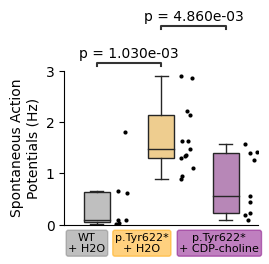

In [111]:
fig, (ax1) = plt.subplots(1, 1, figsize=(2.5, 2))

plt.sca(ax1)

ax1 = plot_boxplot_by_treatment(df_melted, 'line', 'Value', order = ['E3', 'Y', 'Y+C'], pairs = [('E3', 'Y'), ('Y', 'Y+C')],palette={'E3': 'grey', 'Y': 'orange', 'Y+C': 'purple'}, 
                                ylim = np.max(df_melted['Value']+0.1) )

ax1.set_xticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel('Spontaneous Action\nPotentials (Hz)')

ax1.text(-0.15, -0.05, "WT\n+ H2O", ha='center', va='top', transform=ax1.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="grey", ec="grey", alpha=0.5), fontsize=8)
ax1.text(0.7, -0.05, "p.Tyr622*\n+ H2O", ha='center', va='top', transform=ax1.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="orange", ec="orange", alpha=0.5), fontsize=8)
ax1.text(1.9, -0.05, "p.Tyr622*\n+ CDP-choline", ha='center', va='top', transform=ax1.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="purple", ec="purple", alpha=0.5), fontsize=8)


#plt.subplots_adjust(left=0.07, right=0.9, top=0.8, bottom=0.08, wspace=0.4)

plt.savefig('../../paper/main_plots/cortical_organoids_ephys.png', dpi=300, bbox_inches='tight')